In [1]:
# !pip install -q git+https://github.com/EfficientDL/codelab_utils.git

import pickle
import PIL
import math

import tensorflow as tf
import tensorflow_datasets as tfds
import codelab_utils.mpl_styles as mpl_styles
import numpy as np

from tensorflow.keras import layers, optimizers, metrics, losses, utils
from tensorflow.keras import applications as apps, callbacks as cbs
from tensorflow.keras.utils import plot_model
from matplotlib import pyplot as plt
from itertools import accumulate
from functools import reduce

mpl_styles.set_default_styles()
plt.rcParams['font.family'] = 'Poppins'

In [2]:
# Load Oxford-IIIT Pet Dataset
train_ds, val_ds, test_ds = tfds.load(
    'oxford_iiit_pet:3.*.*',
    split=['train[:80%]', 'train[80%:]', 'test'],
    read_config=tfds.ReadConfig(try_autocache=False)
)

Metal device set to: Apple M1

systemMemory: 8.00 GB
maxCacheSize: 2.67 GB



2023-03-30 10:38:48.439986: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-03-30 10:38:48.440451: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [3]:
IMG_SIZE = 128

def to_binary(x, classId, threshold=0.5):
    selection_cond = (x >= classId - threshold) & (x < classId + threshold)
    return tf.where(selection_cond, tf.ones_like(x), tf.zeros_like(x))

def preprocess(item):
    image, mask = item['image'], item['segmentation_mask']

    # Resize image and mask to IMG_SIZE
    image = tf.image.resize(image, [IMG_SIZE, IMG_SIZE])
    mask = tf.image.resize(mask, [IMG_SIZE, IMG_SIZE])


    # Normalize the image and realign the mask.
    image = tf.cast(image, tf.float32) / 255.0
    mask = to_binary(mask, 1)
    
    return image, mask

train_prep_ds = train_ds.map(preprocess, num_parallel_calls=tf.data.AUTOTUNE)
val_prep_ds = val_ds.map(preprocess, num_parallel_calls=tf.data.AUTOTUNE)
test_prep_ds = test_ds.map(preprocess, num_parallel_calls=tf.data.AUTOTUNE)

2023-03-30 10:38:48.664202: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


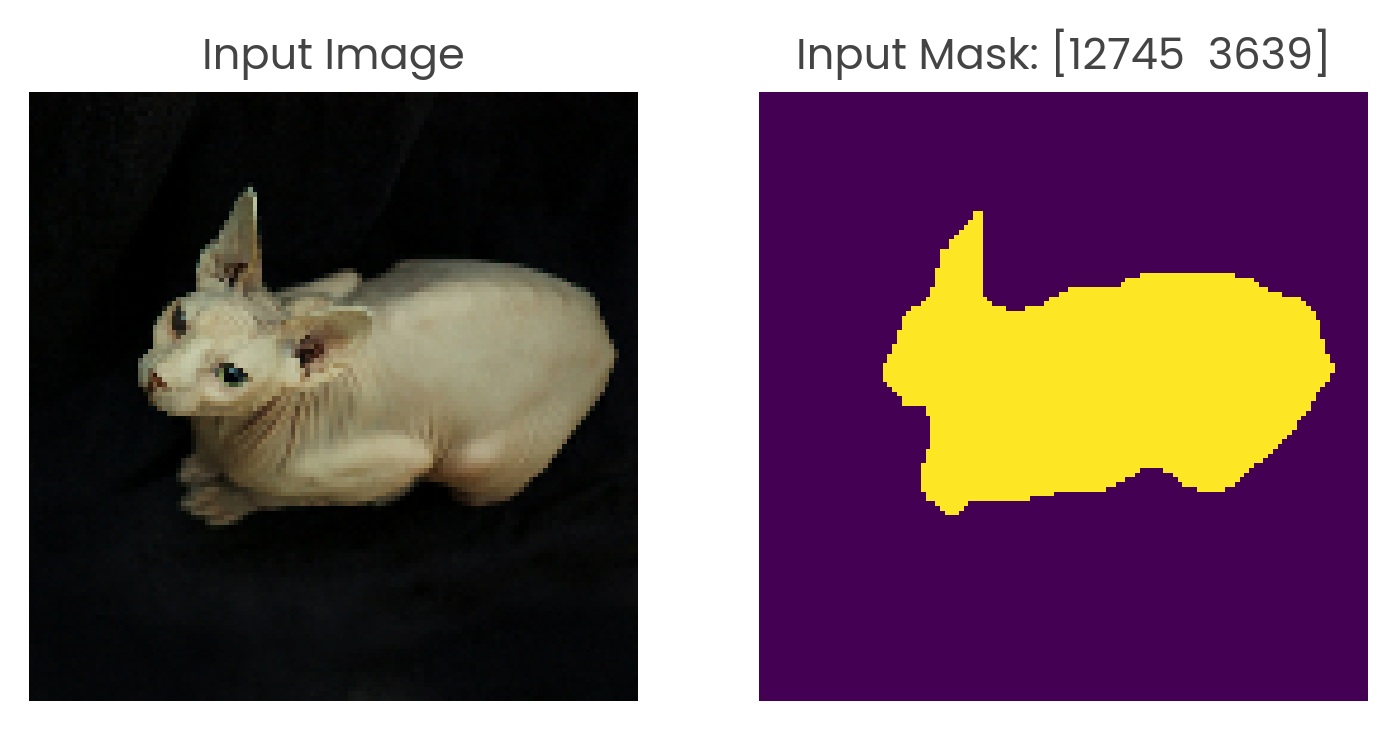

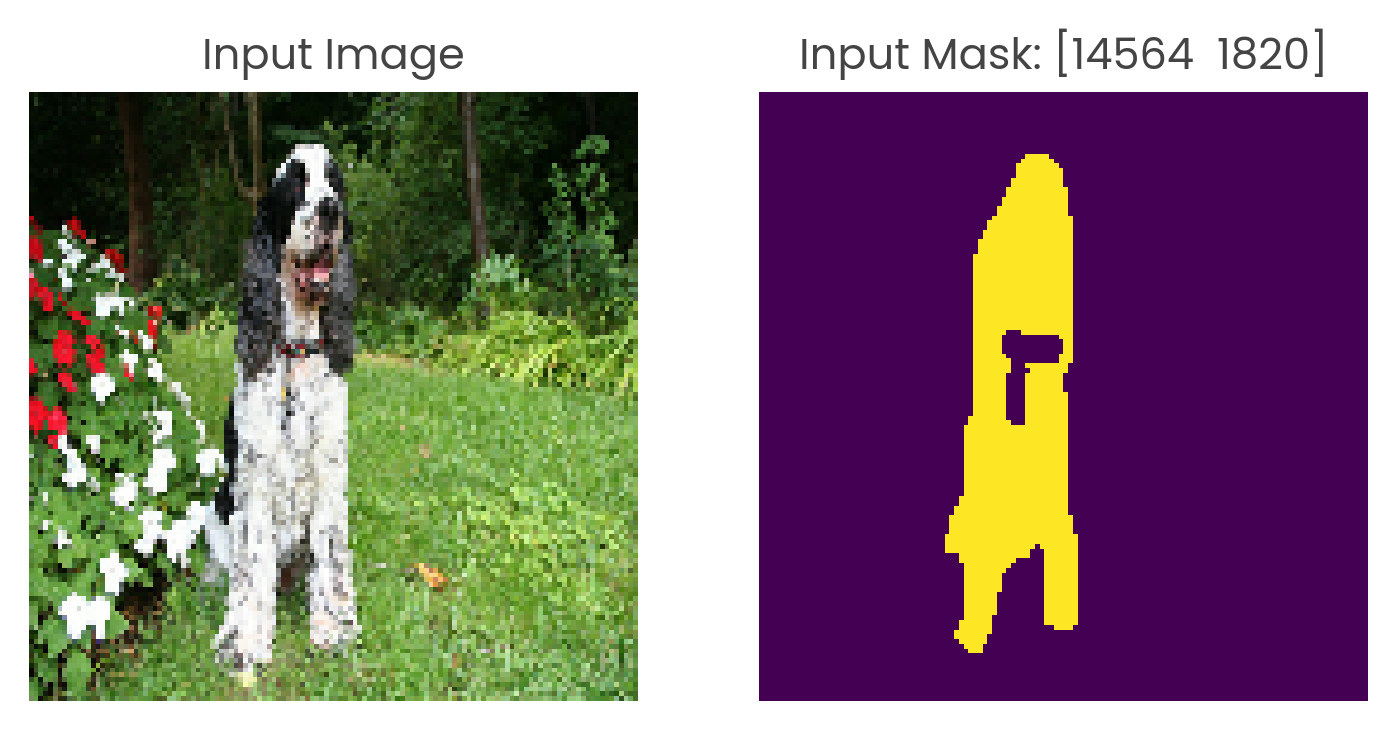

In [4]:
def plot_grid(images, cols=5):
    rows = (len(images)+cols-1)//cols
    fig, axes = plt.subplots(rows, cols)

    def axis_off(ax):
        ax.set_axis_off()
        return ax

    raveled_axes = list(map(axis_off, axes.ravel()))

    for index, name in enumerate(images):
        ax = raveled_axes[index]
        image = images[name]
        ax.imshow(image) if len(
            image.shape) == 3 else ax.imshow(image, cmap='gray')
        ax.set_title(name)


for image, mask in train_prep_ds.take(2):
    mask_frequencies = np.unique(mask, return_counts=True)
    sample = {'Input Image': image, 'Input Mask: {}'.format(mask_frequencies[1]): mask}
    plot_grid(sample, cols=2)

## Network Blocks

In [47]:
INITIAL_WIDTH = 64
DROPOUT_RATE = 0.6
DEBUG = False

### Attention

In [45]:
def attention_block(x, g, dims):
    """
        x: Feature map from skip connection.
        g: Feature map from the last layer. It has smaller spatial dimensions
    """

    # Transform x with strided convolution to match gating dimensions
    stride_x = x.shape[1]//g.shape[1]
    # print('Initial Shapes: ', x.shape, g.shape, stride_x)
    x_transform = layers.Conv2D(dims, 3, (stride_x, stride_x), padding="same")(x)

    # Transform g with 1x1 convolution
    g_transform = layers.Conv2D(dims, 1, padding="same")(g)
    # print('x_transform: ', x_transform.shape, 'g_transform: ', g_transform.shape)

    # Combine transformed x and g and transform them to a single channel output
    # which will be used to scale the input x. A sigmoid function is applied
    # to the comination to ensure scaling factors in range [0,1)
    x_g_combined = layers.Activation('relu')(x_transform + g_transform)
    x_g_collapsed = layers.Conv2D(1, 1, padding='same', activation="relu")(x_g_combined)

    # Match the computed weights to the input x.
    attention_weights = layers.UpSampling2D((stride_x, stride_x))(x_g_collapsed)
    attention_weights = tf.repeat(attention_weights, x.shape[-1], axis=-1)
    # print('attention_weights: ', attention_weights.shape)

    # Scale input x with attention
    scaled_x = attention_weights * x

    # Apply another convolution to compute the output
    output = layers.Conv2D(x.shape[-1], 1, padding='same')(scaled_x)
    output = layers.BatchNormalization()(output)

    # print('attention_block: ', output.shape)
    return output

# x = tf.random.normal((1, 32, 32, 64))
# g = tf.random.normal((1, 16, 16, 128))

# attention_block(x, g, 32)

### Encoder

In [ ]:
def encoder_block(input, width_multiplier, name='block'):
    conv_1 = layers.Conv2D(INITIAL_WIDTH*width_multiplier,
                           (3, 3), activation="relu", padding="same")(input)
    conv_2 = layers.Conv2D(INITIAL_WIDTH*width_multiplier,
                           (3, 3), activation="relu", padding="same")(conv_1)
    normalization = layers.BatchNormalization()(conv_2)
    pool = layers.MaxPooling2D((2, 2))(normalization)
    dropout = layers.Dropout(DROPOUT_RATE)(pool)

    if DEBUG:
        print(name, input.shape, conv_1.shape, conv_2.shape, pool.shape)

    return dropout

def central_crop(x, target_size):
    current_size = x.shape[1]
    extra_size = current_size - target_size
    start = extra_size//2
    end = start+target_size
    return x[:, start:end, start:end, :]

def decoder_block(input, skip_input, width_multiplier, name='block'):
    # Apply attention to the skip input
    attended_skip_input = attention_block(skip_input, input, INITIAL_WIDTH*width_multiplier)

    conv_transpose = layers.Conv2DTranspose(
        INITIAL_WIDTH*width_multiplier, (3, 3), strides=(2, 2), padding='same')(input)

    cropped_skip_input = central_crop(attended_skip_input, conv_transpose.shape[1])
    conv_input = layers.Concatenate()([conv_transpose, cropped_skip_input])

    conv_1 = layers.Conv2D(INITIAL_WIDTH*width_multiplier,
                           (3, 3), activation="relu", padding="same")(conv_input)
    conv_2 = layers.Conv2D(INITIAL_WIDTH*width_multiplier,
                           (3, 3), activation="relu", padding="same")(conv_1)
    normalization = layers.BatchNormalization()(conv_2)
    
    dropout = layers.Dropout(DROPOUT_RATE)(normalization)
    # dropout = layers.Dropout(DROPOUT_RATE)(conv_2)

    if DEBUG:
        print(name, conv_input.shape, conv_1.shape, conv_2.shape)

    return dropout

Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_17 (InputLayer)          [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_213 (Conv2D)            (None, 128, 128, 64  1792        ['input_17[0][0]']               
                                )                                                                 
                                                                                                  
 conv2d_214 (Conv2D)            (None, 128, 128, 64  36928       ['conv2d_213[0][0]']             
                                )                                                           

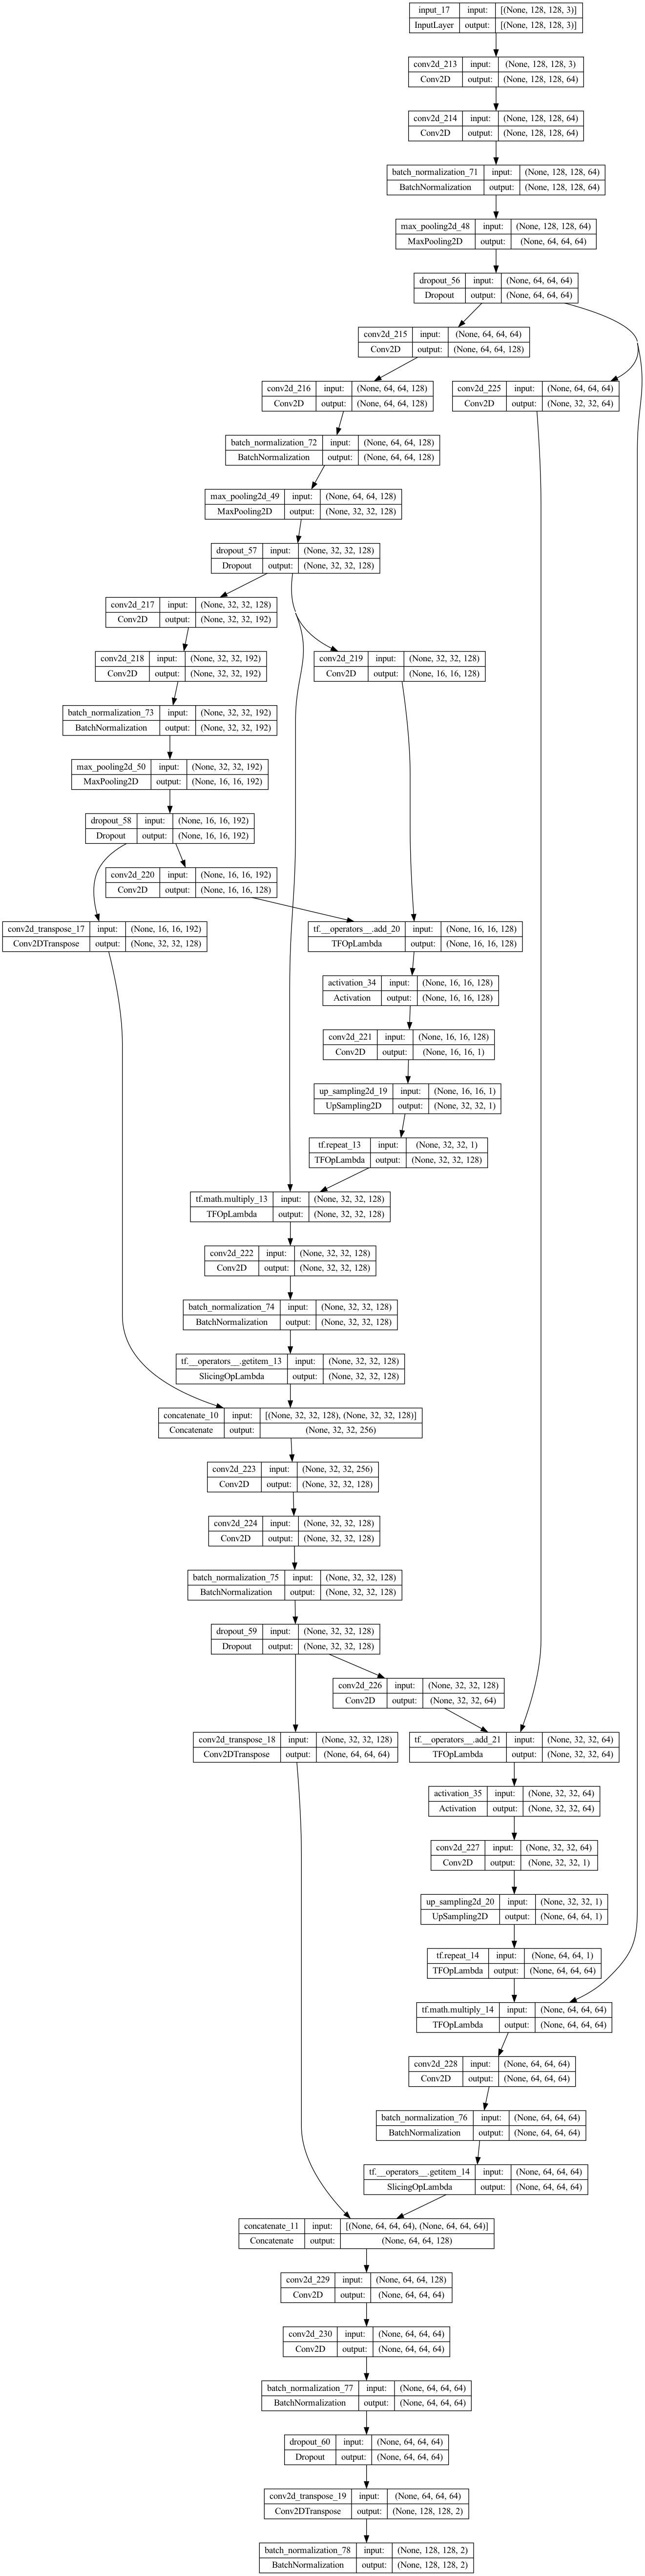

In [57]:
N_ENCODERS = 2
N_CLASSES = 2
LEARNING_RATE = 0.0003
STEPS_PER_EPOCH = 184

def resize_block(input):
    conv_transpose = layers.Conv2DTranspose(
        N_CLASSES, 3, strides=(2, 2), padding='same')(input)
    # conv_transpose_2 = layers.Conv2DTranspose(
    #     N_CLASSES, (3, 3), strides=(2, 2), padding='same')(conv_transpose_1)
    
    # conv_1 = layers.Conv2D(input.shape[-1]//4,
    #                        (9, 9), activation="relu", padding="valid")(conv_transpose_2)
    # conv_2 = layers.Conv2D(N_CLASSES,
    #                        (9, 9), activation="relu", padding="valid")(conv_1)

    normalization = layers.BatchNormalization()(conv_transpose)
    # cropped = central_crop(normalization, IMG_SIZE)
    # cropped = central_crop(conv_transpose_2, IMG_SIZE)
                                    
    return normalization

def iou_loss(from_logits=False):
    # transform = lambda x: tf.math.sigmoid(x) if from_logits else x
    transform = lambda x: tf.math.softmax(x) if from_logits else x

    # def iou(y_true, y_pred):
    #     y_pred = transform(y_pred)
    #     intersection = y_true * y_pred
    #     union = y_true + (1 - y_true)*y_pred
    #     return 1 - tf.reduce_sum(intersection)/tf.reduce_sum(union)
    
    def iou(y_true, y_pred):
        y_pred = tf.split(transform(y_pred), y_pred.shape[-1], axis=-1)[1]
        intersection = y_true * y_pred
        union = y_true + (1 - y_true)*y_pred
        return 1 - tf.reduce_sum(intersection)/tf.reduce_sum(union)
    
    return iou

class IoUMetric(metrics.BinaryIoU):
    def __init__(self, name='iou', from_logits=False, **kwargs):
        super().__init__(name=name, **kwargs)
        self.transform = lambda x: tf.math.softmax(x) if from_logits else x

    def update_state(self, y_true, y_pred, sample_weight=None):
        y_pred = tf.split(self.transform(y_pred), y_pred.shape[-1], axis=-1)[1]
        super().update_state(y_true, y_pred)

def create_model():
    inp = tf.keras.Input((IMG_SIZE, IMG_SIZE, 3))

    encoder_blocks = list(accumulate([inp] + list(range(1, N_ENCODERS+1)), lambda x,
                                     idx: encoder_block(x, idx, name='ENC_BLOCK_{}'.format(idx))))

    # Remove the initial input from the list of encoder blocks
    encoder_blocks.pop(0)

    # Create the mid block. It is kept separate from the encoder blocks
    # because it doesn't have a corresponding decoder block.
    mid_block = encoder_block(
        encoder_blocks[-1], N_ENCODERS+1, name='MID_BLOCK')

    decoder_blocks = list(accumulate([mid_block] + list(enumerate(reversed(encoder_blocks))), lambda x, item: decoder_block(
        x, item[1], N_ENCODERS - item[0], 'DEC_BLOCK_{}'.format(item[0]+1))))

    # Remove the mid block from the list of decoder blocks
    decoder_blocks.pop(0)

    output = resize_block(decoder_blocks[-1])
    m = tf.keras.Model(inputs=inp, outputs=output)
    lr_schedule = optimizers.schedules.InverseTimeDecay(
        LEARNING_RATE,
        decay_steps=STEPS_PER_EPOCH*10,
        decay_rate=0.75,
        staircase=False)
    optimizer = optimizers.Adam(lr_schedule)
    # loss = losses.SparseCategoricalCrossentropy(from_logits=True)
    # loss = tf.keras.losses.BinaryCrossentropy(from_logits=True)
    # m.compile(loss=loss, optimizer=optimizer, metrics='accuracy')
    loss = iou_loss(from_logits=True)
    # metric = metrics.BinaryIoU(target_class_ids=[1], threshold=0.4, name='accuracy')
    metric = IoUMetric(name='accuracy', from_logits=True)
    m.compile(loss=loss, optimizer=optimizer, metrics='accuracy')
    # m.compile(loss=loss, optimizer=optimizer, metrics=metric)

    return m


model = create_model()
model.summary()

utils.plot_model(model, show_shapes=True)

In [50]:
def train(model, tds, vds, epochs=100, callbacks=[]):
    # tds = tds.prefetch(buffer_size=tf.data.AUTOTUNE)
    # vds = vds.prefetch(buffer_size=tf.data.AUTOTUNE) if vds else None
    tds = tds.prefetch(buffer_size=tf.data.AUTOTUNE).take(1)
    vds = vds.prefetch(buffer_size=tf.data.AUTOTUNE).take(1) if vds else None
    history = model.fit(tds, validation_data=vds, epochs=epochs, callbacks=callbacks)

    return history

In [51]:
checkpoint_name_tmpl = 'weights-epoch-{epoch:d}-val_accuracy-{val_accuracy:.4f}.h5'
checkpoint = cbs.ModelCheckpoint(checkpoint_name_tmpl, save_best_only=True, monitor="val_accuracy")

EPOCHS = 2
# EPOCHS = 50
BATCH_SIZE = 16

callbacks = [checkpoint]
tds = train_prep_ds.cache().shuffle(1000, reshuffle_each_iteration=True).batch(BATCH_SIZE)
vds = val_prep_ds.batch(256).cache()

hist = train(model, tds, vds, epochs=EPOCHS, callbacks=callbacks)

with open('training.results.pkl', 'wb') as f:
    pickle.dump(hist.history, f)

Epoch 1/2


2023-03-30 12:01:15.196300: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
Corrupt JPEG data: 240 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment


1/1 [==============================] - ETA: 0s - loss: 0.7711 - accuracy: 0.5022

2023-03-30 12:01:20.000032: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 9s 9s/step - loss: 0.7711 - accuracy: 0.5022 - val_loss: 0.7706 - val_accuracy: 0.4151


2023-03-30 12:01:22.607101: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


Epoch 2/2


2023-03-30 12:01:22.827138: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.
Corrupt JPEG data: 240 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment


1/1 [==============================] - 4s 4s/step - loss: 0.7392 - accuracy: 0.5000 - val_loss: 0.7706 - val_accuracy: 0.3871


2023-03-30 12:01:26.925436: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.
2023-03-30 12:01:26.949289: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


{'loss': [0.7711372375488281, 0.7391514778137207],
 'accuracy': [0.502227783203125, 0.5000419616699219],
 'val_loss': [0.77064049243927, 0.770574688911438],
 'val_accuracy': [0.4151039123535156, 0.3870577812194824]}

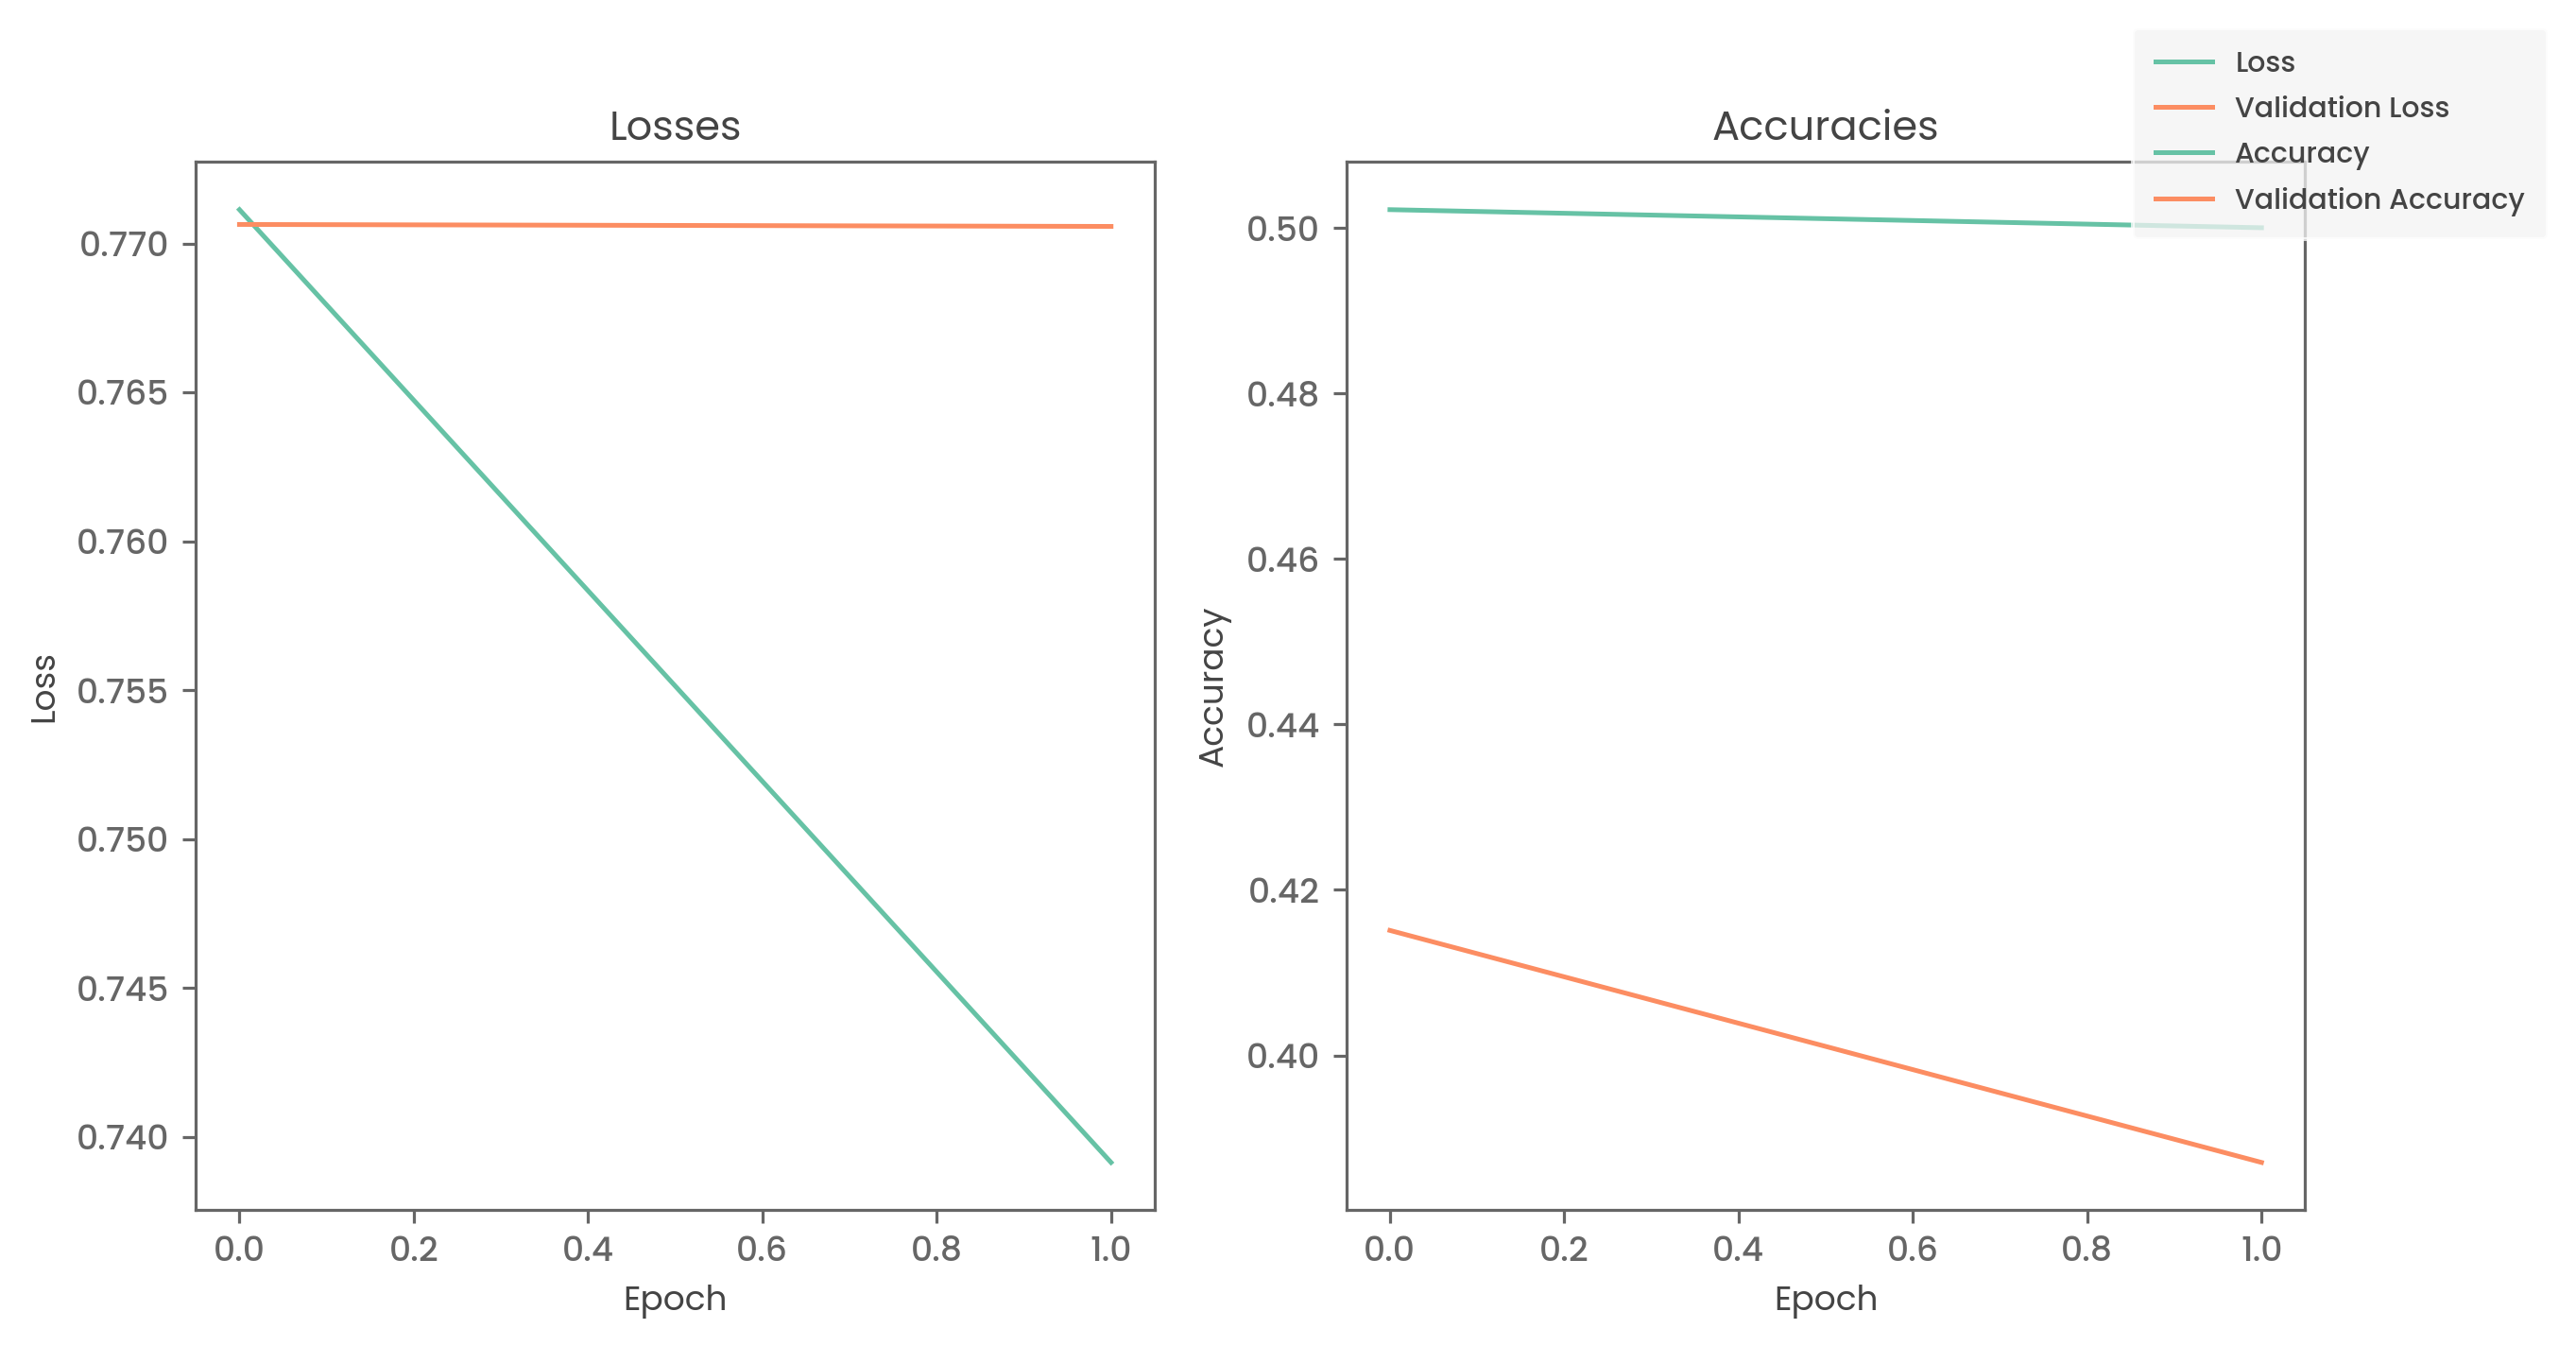

In [52]:
def plot_history(h):
    fig, axes = plt.subplots(1, 2, figsize=(10, 5), facecolor='w', edgecolor='k')

    axes[0].plot(h['loss'], label='Loss')
    axes[0].plot(h['val_loss'], label='Validation Loss')

    axes[0].set_xlabel('Epoch')
    axes[0].set_ylabel('Loss')
    axes[0].set_title('Losses')

    axes[1].plot(h['accuracy'], label='Accuracy')
    axes[1].plot(h['val_accuracy'], label='Validation Accuracy')

    axes[1].set_xlabel('Epoch')
    axes[1].set_ylabel('Accuracy')
    axes[1].set_title('Accuracies')

    fig.legend()

plot_history(hist.history)
hist.history

In [9]:
model.evaluate(test_prep_ds.batch(256))

15/15 [==============================] - 18s 1s/step - loss: 0.7710 - accuracy: 0.5886


[0.7710474133491516, 0.5886284708976746]

In [53]:
batch = iter(train_prep_ds.shuffle(buffer_size=5).batch(5)).next()


(<tf.Tensor: shape=(), dtype=float32, numpy=1.0>,
 (array([0. , 0.9], dtype=float32), array([9704, 6680])))

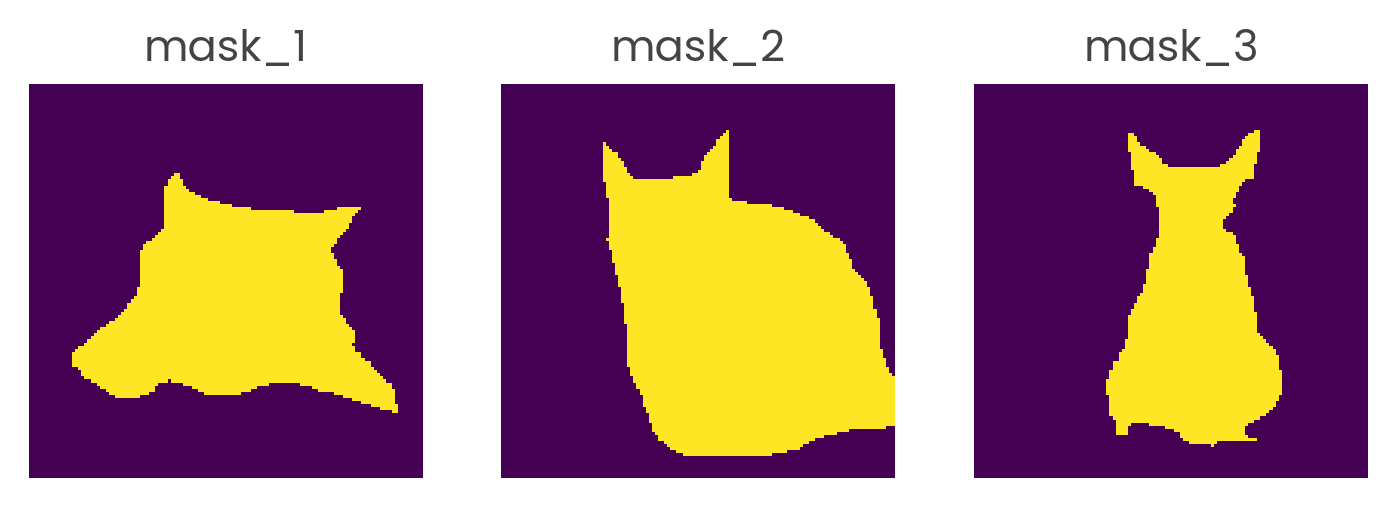

In [54]:
mask_1 = tf.expand_dims(batch[1][0], axis=0)
mask_2 = tf.expand_dims(batch[1][1], axis=0)
mask_3 = tf.expand_dims(batch[1][2], axis=0)

plot_grid({
    'mask_1': tf.squeeze(mask_1, axis=0),
    'mask_2': tf.squeeze(mask_2, axis=0),
    'mask_3': tf.squeeze(mask_3, axis=0),
    }, cols=3)

iou_metric = metrics.BinaryIoU(target_class_ids=[1], threshold=0.5)
iou_metric(mask_2, tf.clip_by_value(mask_2-0.4, 0, 1)), np.unique(tf.clip_by_value(mask_2-0.1, 0, 1), return_counts=True)

# iou_metric(tf.clip_by_value(mask_2-0.1, 0, 1), mask_2), iou_metric(mask_1, mask_3), iou_metric(mask_3, mask_2),


In [12]:
# model.load_weights('/Users/broxoli/Downloads/weights-epoch-1-val_accuracy-0.2955.h5')

ValueError: Layer count mismatch when loading weights from file. Model expected 20 layers, found 14 saved layers.

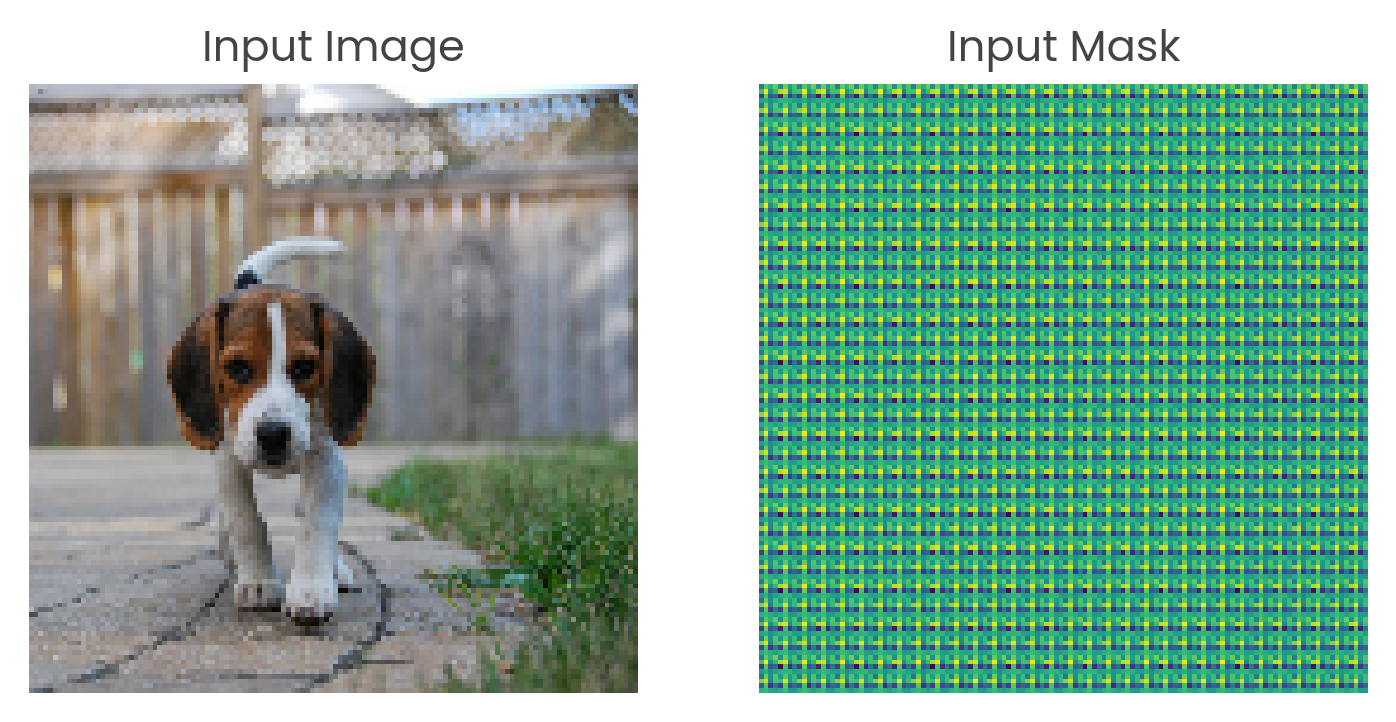

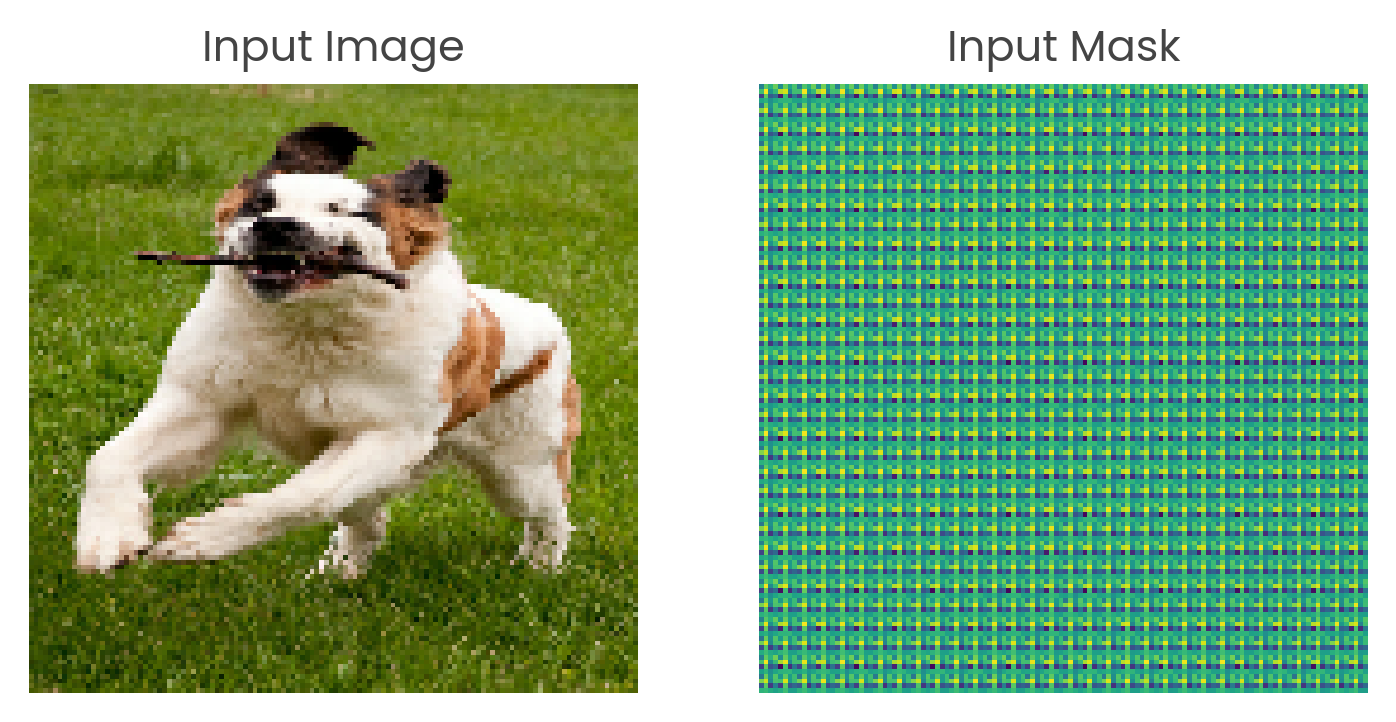

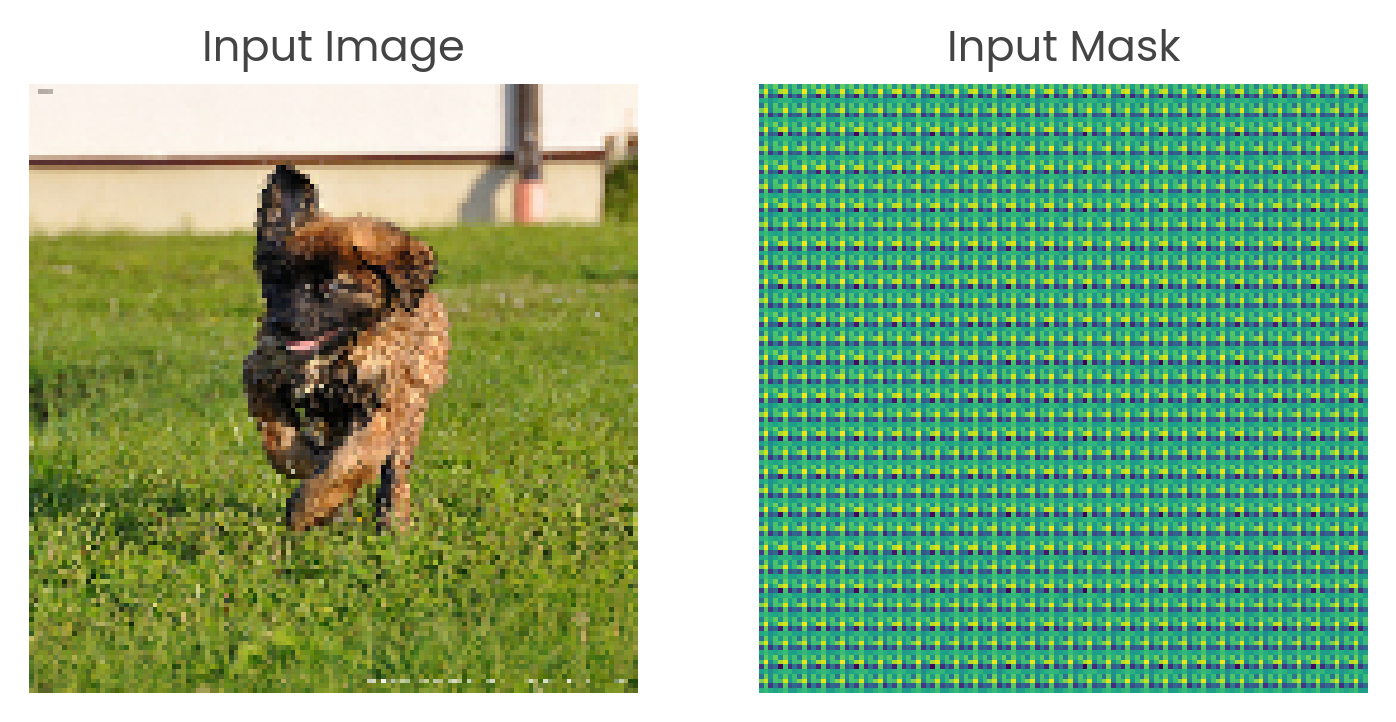

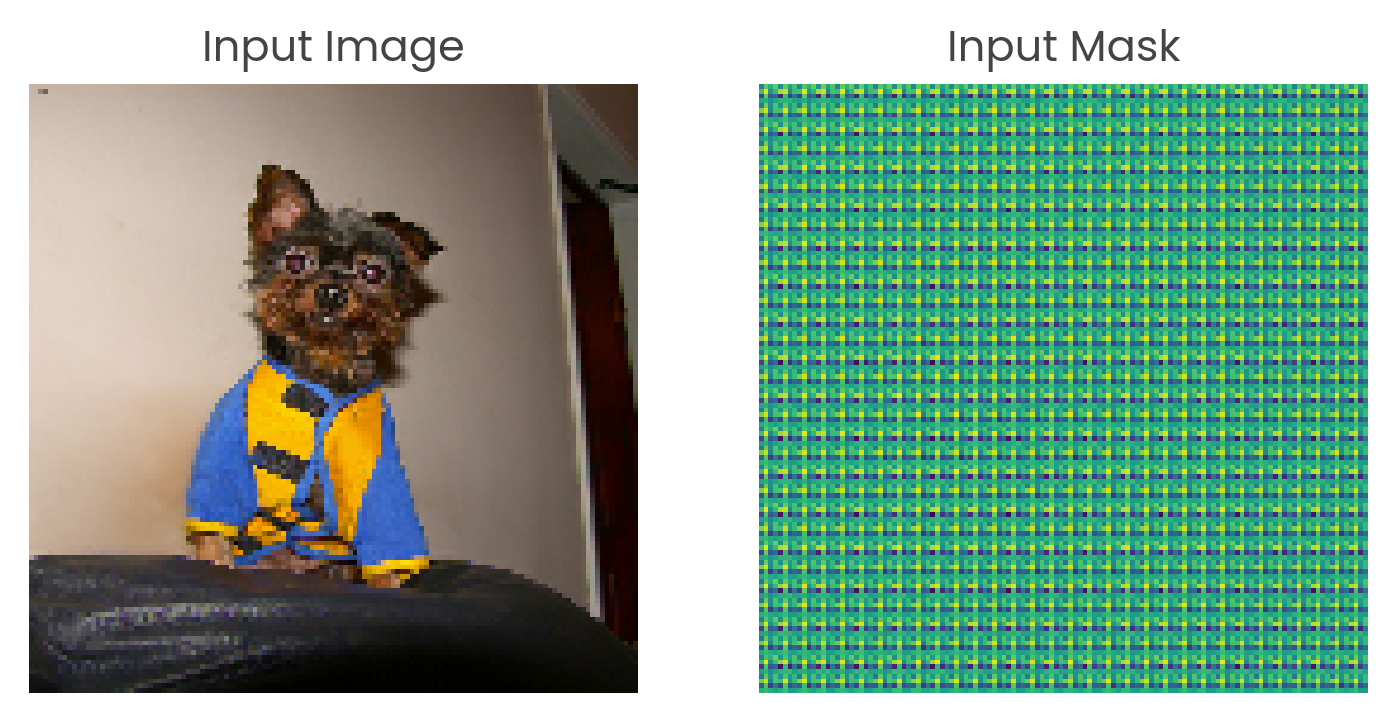

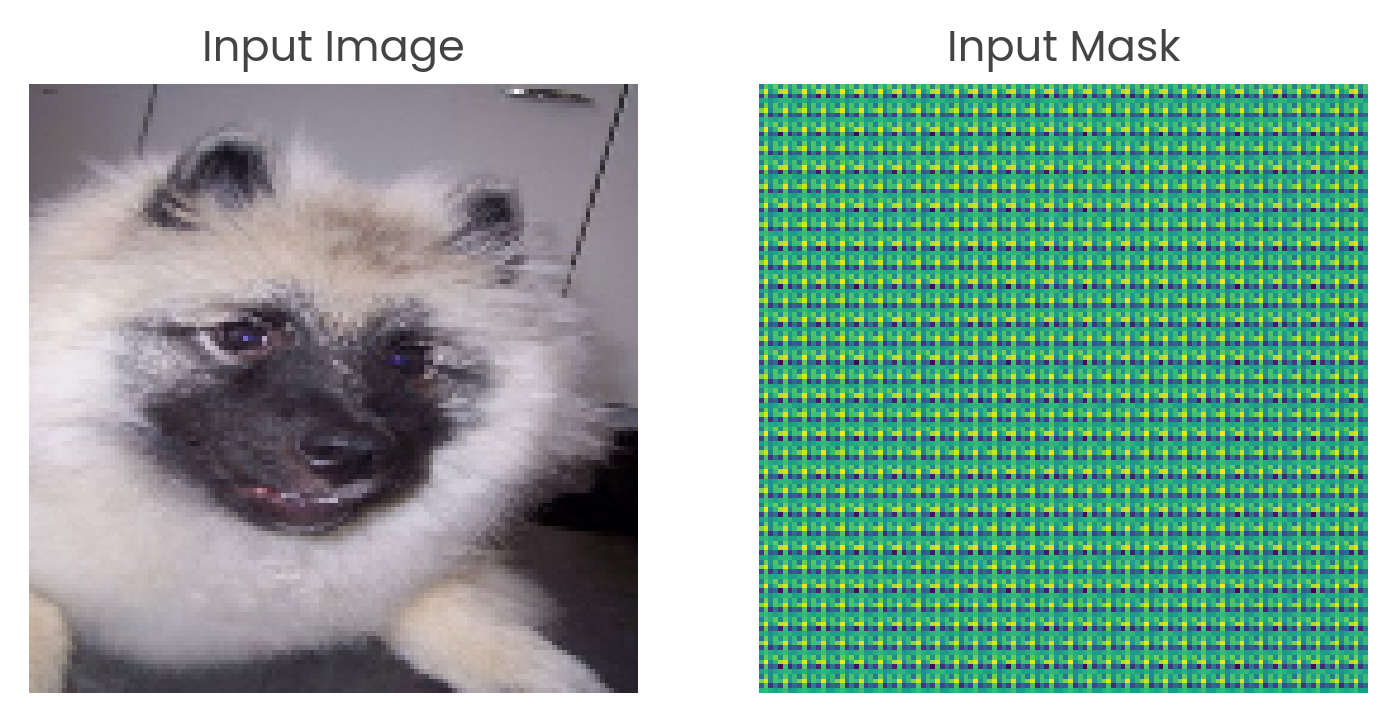

In [55]:
batch = iter(test_prep_ds.shuffle(buffer_size=5).batch(5)).next()
# masks = tf.expand_dims(tf.math.argmax(tf.math.softmax(model(batch[0]), axis=-1), axis=-1), axis=-1)
# masks = to_binary(tf.math.sigmoid(model(batch[0])), 1)
masks = tf.split(tf.math.softmax(model(batch[0])), 2, axis=-1)[1]

for image, mask in zip(batch[0], masks):
    sample = {'Input Image': image, 'Input Mask': mask}
    plot_grid(sample, cols=2)
# masks.shape

In [ ]:
x = tf.ones((3,3,2))
x, tf.split(x, x.shape[-1], axis=-1)[1].shape

(<tf.Tensor: shape=(3, 3, 2), dtype=float32, numpy=
 array([[[1., 1.],
         [1., 1.],
         [1., 1.]],
 
        [[1., 1.],
         [1., 1.],
         [1., 1.]],
 
        [[1., 1.],
         [1., 1.],
         [1., 1.]]], dtype=float32)>,
 TensorShape([3, 3, 1]))